# Setup

In [1]:
!pip install finlab_crypto > log.txt

import finlab_crypto
finlab_crypto.setup()

ohlcv = finlab_crypto.crawler.get_all_binance('BTCUSDT', '1d')

All caught up..!


# Bitcoin Hash Rate

In [2]:
from finlab_crypto.crawler import GlassnodeClient
from datetime import timezone
import datetime

# glassnode crawler
def get_glassnode(url, api_key, index):

    gn = GlassnodeClient()
    gn.api_key = api_key
    ret = gn.get(url)
    ret.index = ret.index + datetime.timedelta(days=1)
    ret.index = ret.index.tz_localize(timezone.utc)
    ret = ret.reindex(index, method='ffill').ffill()
    return ret.astype(float)

hash_rate = get_glassnode('https://api.glassnode.com/v1/metrics/mining/hash_rate_mean',
                          '5a7f395a-9633-40de-b2d3-c211e9d9259c', ohlcv.index)

hash_rate.plot()

401 Client Error: Unauthorized for url: https://api.glassnode.com/v1/metrics/mining/hash_rate_mean?a=BTC&i=24h&c=native&api_key=5a7f395a-9633-40de-b2d3-c211e9d9259c
<html>
<head><title>401 Authorization Required</title></head>
<body>
<center><h1>401 Authorization Required</h1></center>
<hr><center>nginx</center>
</body>
</html>

Expecting value: line 1 column 1 (char 0)


AttributeError: 'NoneType' object has no attribute 'index'

# Miner capitulation

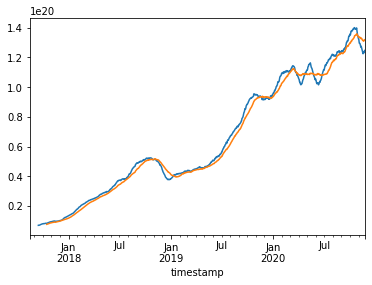

In [ ]:
hash_rate_ma30 = hash_rate.rolling(30).mean()
hash_rate_ma60 = hash_rate.rolling(60).mean()
hash_rate_ma30.plot()
hash_rate_ma60.plot()

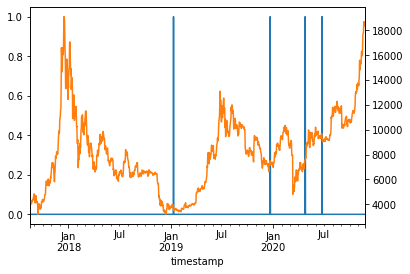

In [ ]:
crossover = ((hash_rate_ma30 > hash_rate_ma60) & (hash_rate_ma30.shift() < hash_rate_ma60.shift()))
# if crossover =1, it is buy signal.
crossover.astype(int).plot()
ohlcv.close.plot(secondary_y=True)


# Statistic analysis

[transpose api reference](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html)

In [ ]:
import pandas as pd

results = {}
# Brcause we use shift func, some top numbers values are NA, use fillna(False) replace to NA values.
for d in range(1, 181, 1):
    close_price = ohlcv[crossover.shift(d).fillna(False)].close.values
    results[d] = pd.Series(close_price)

# Each row of data represents the transaction history record generated by each signal
results = pd.DataFrame(results)
# div = "/", use div to do nomalization
# use transpose to make shape x*y to y*x, in order to plot record
results = results.div(results[1], axis=0).transpose()
results


,0,1,2,3
1,1.000000,1.000000,1.000000,1.000000
2,0.970328,0.991620,1.010597,0.990564
3,1.011990,0.984631,1.005964,0.974324
4,0.991608,0.984271,1.141097,0.985606
5,1.002431,0.991479,1.120485,0.993845
...,...,...,...,...
176,3.141524,1.288220,1.495254,NaN
177,3.183317,1.301828,1.527534,NaN
178,3.415617,1.293566,1.548139,NaN
179,3.500685,1.282794,1.661354,NaN


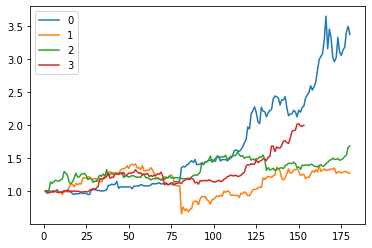

In [ ]:
results.plot()

In [ ]:
# Chosse number to check the price after the transaction
results.loc[[1, 30, 60, 90, 180]]

,0,1,2,3
1,1.000000,1.000000,1.000000,1.000000
30,1.027052,1.193921,1.156926,1.031170
60,1.083614,1.311508,1.208419,1.259327
90,1.400276,0.845552,1.239786,1.138399
180,3.379272,1.272395,1.685734,NaN
